# Effect of data-parameters and model-parameters on bias and variance

## Increasing model complexity increases bias and decreases variance

The model complexity has a direct effect on the bias and variance of the learned model.

Increasing the model complexity decreases the _bias_ because the learned model is more specific towards the data sample. Consequently it can learn all the specific details of the problem domain.

Increasing the model complexity increases _variance_ because the learned model is more specific towards the data sample. Consequently, variations in the data sample will alter the learned model more.

## Increasing effective dataset size decreases bias and variance

The effective dataset size has a direct effect on the bias and variance of the learned model.

Increasing the effective dataset size _decreases_ the _bias_ because the data sample represents the problem domain better. In other words, having an infinite amount of data represents the problem domain exactly and consequently allows for perfect modelling.

Increasing the effective dataset size _decreases_ the _variance_ because there is less variation between data samples. In other words, having an infinite amount of data makes all the data samples the same. 

In [1]:
from math import sqrt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.base import clone
from sklearn.utils import shuffle
from sklearn.ensemble import ExtraTreesRegressor, RandomTreesEmbedding
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import scale
from plotnine import *

In [2]:
def make_dataset(n_train=100, n_repeats=20, feature_noise=None, label_noise=None, irrelevant_features=None):
    x, y = fetch_california_housing(return_X_y=True)
    x, y = shuffle(x, y)
    y = scale(y)
    x = scale(x)
    
    if irrelevant_features is not None:
        x = np.hstack((x, np.random.normal(size=(x.shape[0], irrelevant_features))))
    if feature_noise is not None:
        x += np.random.normal(0.0, feature_noise, x.shape)
    if label_noise is not None:
        y += np.random.normal(0.0, label_noise, y.shape)
    
    n_train = n_train * n_repeats
    x_train, y_train = x[:n_train], y[:n_train]
    x_test, y_test = x[n_train:], y[n_train:]
    return x_train, y_train, x_test, y_test


def learn_predict(estimator, x_train, y_train, x_test):
    return estimator.fit(x_train, y_train).predict(x_test)


def estimate_bias_variance(estimator, x_trains, y_trains, x_test, y_test):
    y_preds = []
    for x_train, y_train in zip(x_trains, y_trains):
        y_preds.append(learn_predict(estimator, x_train, y_train, x_test))
    y_preds = np.vstack(y_preds).T
    
    bias = ((y_preds.mean(axis=1) - y_test) ** 2)
    variance = (y_preds.var(axis=1))
    error = ((y_preds - y_test.reshape(-1, 1)) ** 2).mean(axis=1)
    return bias.mean(),  variance.mean(),  error.mean()


def grid_estimator_bias_variance(base_estimator, param_name, param_values, n_repeats):
    x_train, y_train, x_test, y_test = make_dataset(n_repeats=n_repeats)
    results = []
    for value in param_values:
        estimator = clone(base_estimator).set_params(**{param_name: value})
        x_trains, y_trains = zip(*[(x_train[ind_train], y_train[ind_train]) for _, ind_train in KFold(n_repeats).split(x_train)])
        bias, variance, total_error = estimate_bias_variance(estimator, x_trains, y_trains, x_test, y_test)
        results.append({param_name: value, 'error': bias, 'type': 'bias'})
        results.append({param_name: value, 'error': variance, 'type': 'variance'})
        results.append({param_name: value, 'error': total_error, 'type': 'total'})
    return pd.DataFrame(results)


def grid_dataset_bias_variance(estimator, param_name, param_values, n_repeats):
    results = []
    for value in param_values:
        x_train, y_train, x_test, y_test = make_dataset(n_repeats=n_repeats, **{param_name: value})
        x_trains, y_trains = zip(*[(x_train[ind_train], y_train[ind_train]) for _, ind_train in KFold(n_repeats).split(x_train)])
        bias, variance, total_error = estimate_bias_variance(estimator, x_trains, y_trains, x_test, y_test)
        results.append({param_name: value, 'error': bias, 'type': 'bias'})
        results.append({param_name: value, 'error': variance, 'type': 'variance'})
        results.append({param_name: value, 'error': total_error, 'type': 'total'})
    return pd.DataFrame(results)


def plot_bias_variance(estimator, param_name, param_values, n_repeats=20):
    df = grid_estimator_bias_variance(estimator, param_name, param_values, n_repeats)

    p = ggplot(df, aes(param_name, 'error', color='type', fill='type')) \
        + geom_line() \
        + scale_y_continuous(trans='sqrt') \
        + ggtitle('Effect of %s on %s predictions' % (param_name, estimator.__class__.__name__))
    return p


def plot_dataset_bias_variance(estimator, param_name, param_values, n_repeats=20):
    df = grid_dataset_bias_variance(estimator, param_name, param_values, n_repeats)

    p = ggplot(df, aes(param_name, 'error', color='type', fill='type')) \
        + geom_line() \
        + scale_y_continuous(trans='sqrt') \
        + ggtitle('Effect of %s on %s predictions' % (param_name, estimator.__class__.__name__))
    return p

## Increasing number of attributes per split ($K$) for ExtraTreesRegressor

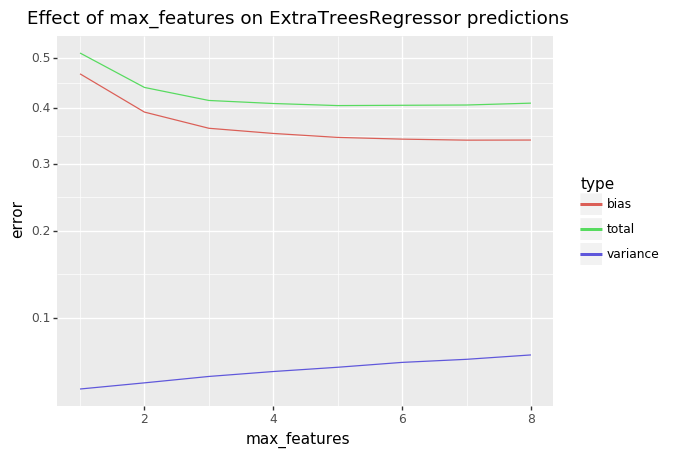

<ggplot: (304883621)>

In [3]:
plot_bias_variance(ExtraTreesRegressor(100), 'max_features', list(range(1, 9)))

... increases complexity. And consequently lowers bias and increases variances. 

## Increasing minimum number of data points ($N_{min}$) for ExtraTreesRegressor

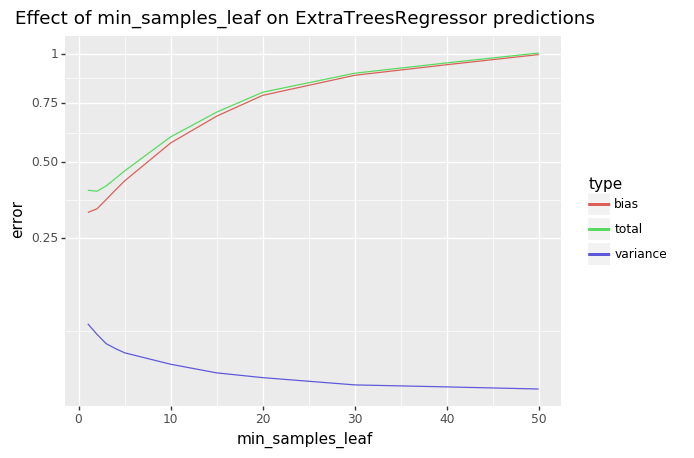

<ggplot: (276998621)>

In [4]:
plot_bias_variance(ExtraTreesRegressor(n_estimators=100), 'min_samples_leaf', [1, 2, 3, 4, 5, 10, 15, 20, 30, 40, 50])

... decreases complexity. And consequently increases bias and lowers variance.

## Increasing number of trees ($M$) for ExtraTreesRegressor

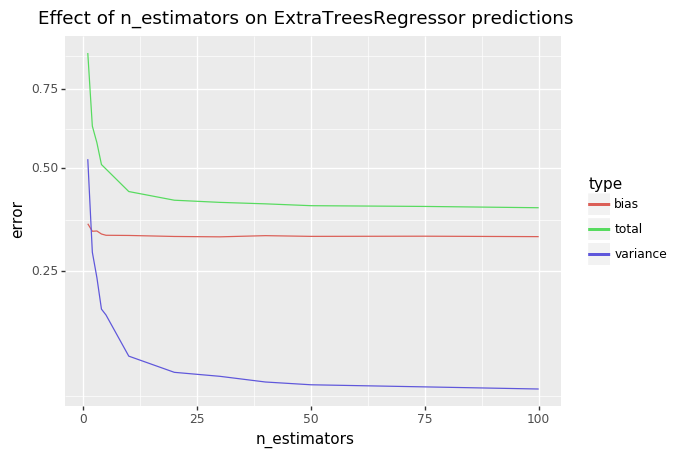

<ggplot: (306888157)>

In [5]:
plot_bias_variance(ExtraTreesRegressor(), 'n_estimators', [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 75, 100])


...does not change complexity. But it does lower the variance by averaging many (different) models. This has nothing to do with model complexity. 

## Using bootstrapping for ExtraTreesRegressor

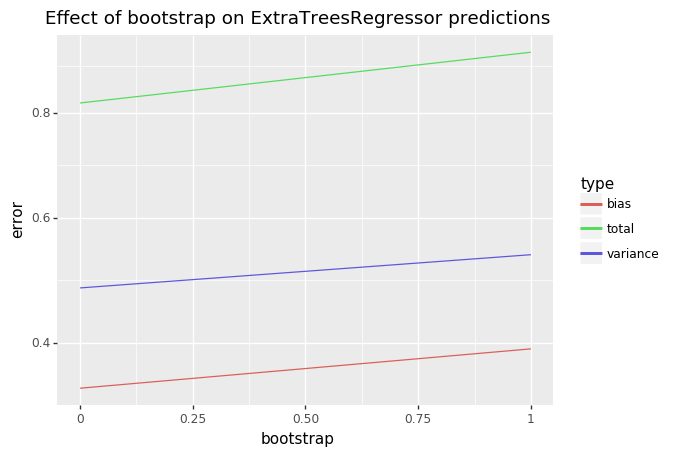

<ggplot: (310618817)>

In [29]:
plot_bias_variance(ExtraTreesRegressor(n_estimators=1), 'bootstrap', [0, 1])

... does not change complexity, but does lower "effective dataset size". Consequently, increases the bias and variance of a single tree. 

## Increasing maximum depth of a DecisionTreeRegressor

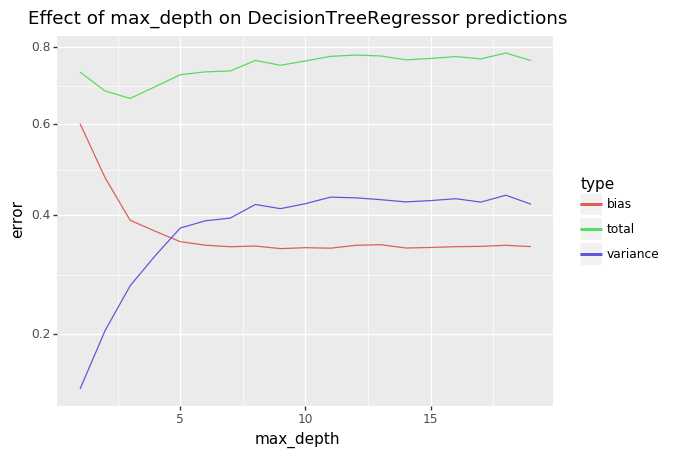

<ggplot: (307722689)>

In [6]:
plot_bias_variance(DecisionTreeRegressor(), 'max_depth', range(1, 20))

... increases complexity. And consequently lowers bias and increases variance.

## Increasing number of neighbours for KNeighborsRegressor

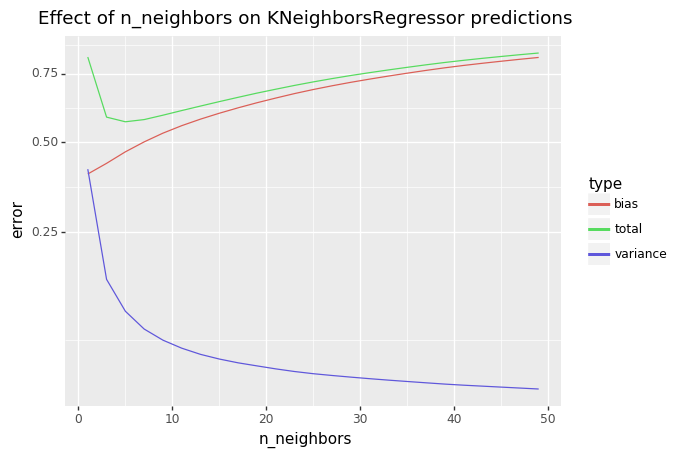

<ggplot: (308254861)>

In [7]:
plot_bias_variance(KNeighborsRegressor(n_jobs=-1), 'n_neighbors', range(1, 51, 2))

... decreases complexity. And consequently increases bias and lowers variance.

## Increasing penalty on error for SVR

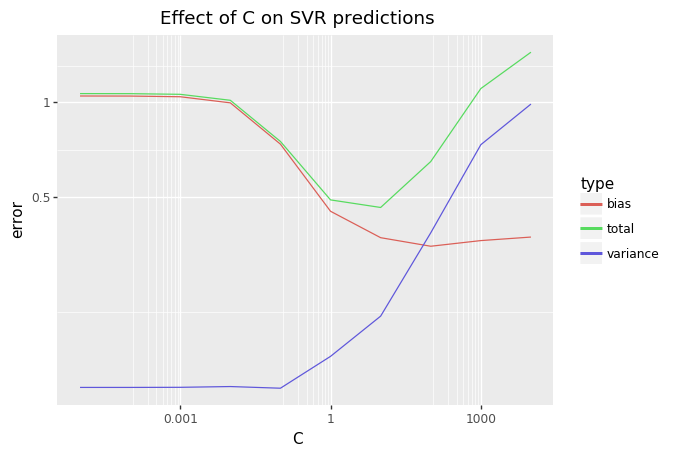

<ggplot: (308260849)>

In [8]:
plot_bias_variance(SVR(gamma='scale'), 'C', [10**i for i in range(-5, 5)]) \
    + scale_x_log10()

... increases complexity. And consequently decreases bias and increases variance.

## Increasing maximum depth for RandomTreesEmbedding

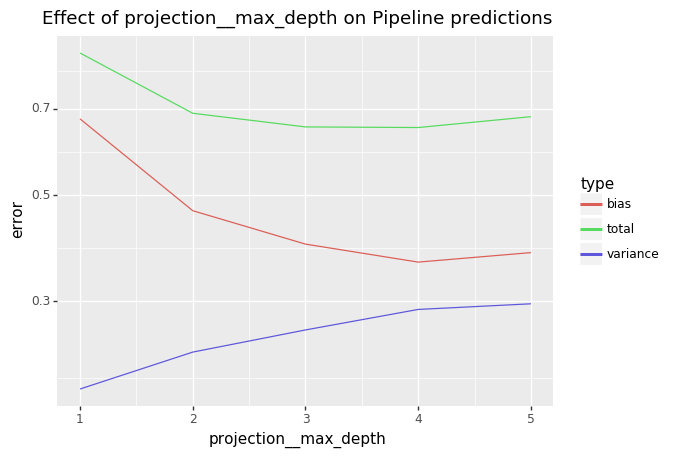

<ggplot: (308200401)>

In [9]:
pipeline = Pipeline([('projection', RandomTreesEmbedding(10)), ('lr', Ridge())])
plot_bias_variance(pipeline, 'projection__max_depth', range(1, 6))

... increases complexity. And consequently lowers bias and increases variance.

## Increasing dataset size

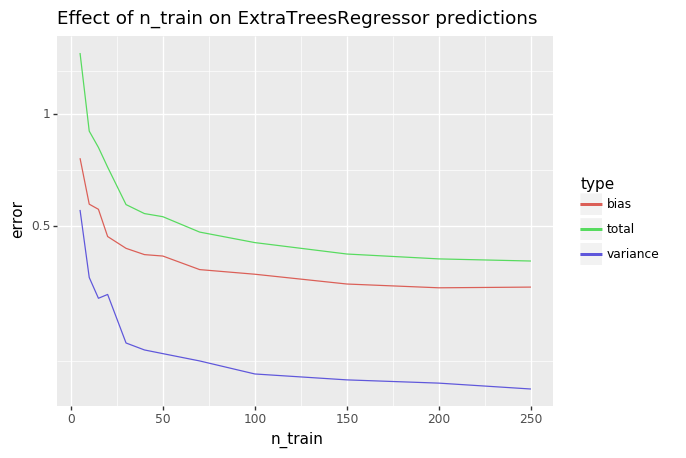

<ggplot: (308309521)>

In [10]:
plot_dataset_bias_variance(ExtraTreesRegressor(100), 'n_train', [5, 10, 15, 20, 30, 40, 50, 70, 100, 150, 200, 250])

... increases "effective dataset size". And consequently lowers bias and variance.

## Increasing additional Gaussian noise on features

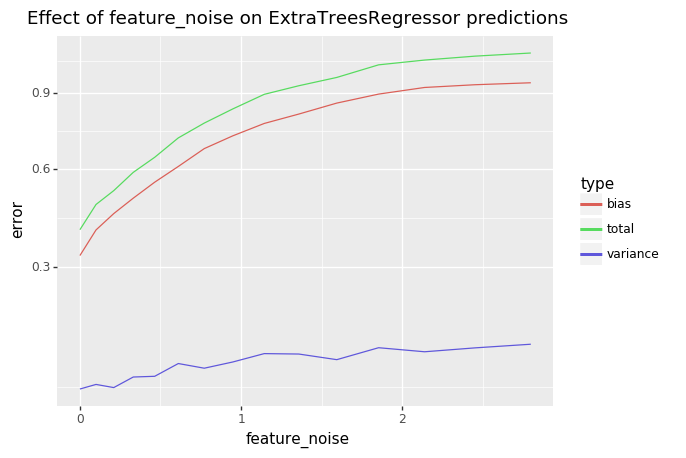

<ggplot: (307748961)>

In [11]:
plot_dataset_bias_variance(ExtraTreesRegressor(100), 'feature_noise', [(1.1 ** i) - 1.0 for i in range(15)])

... decreases "effective dataset size". And consequently increases bias.

## Increasing Gaussian noise on labels

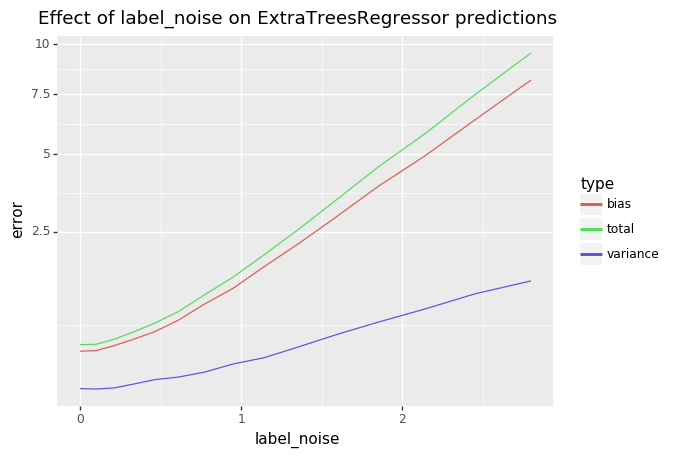

<ggplot: (307799409)>

In [12]:
plot_dataset_bias_variance(ExtraTreesRegressor(100), 'label_noise', [(1.1 ** i) - 1.0 for i in range(15)])

... decreases "effective dataset size". And consequently increases bias.

## Increasing number of irrelevant features

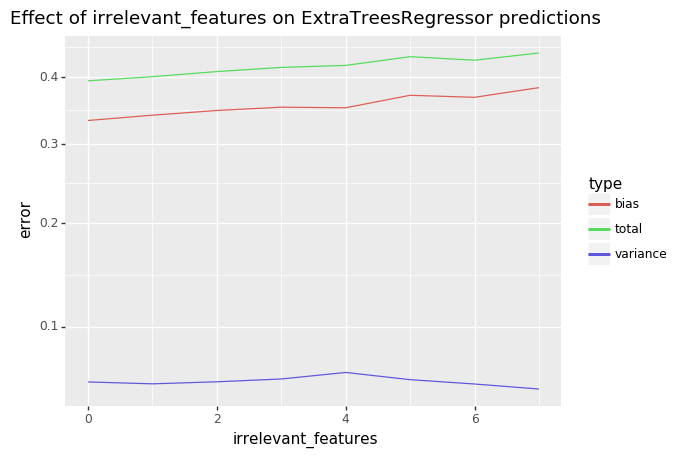

<ggplot: (308501597)>

In [13]:
plot_dataset_bias_variance(ExtraTreesRegressor(100, max_features='auto'), 'irrelevant_features', range(8))

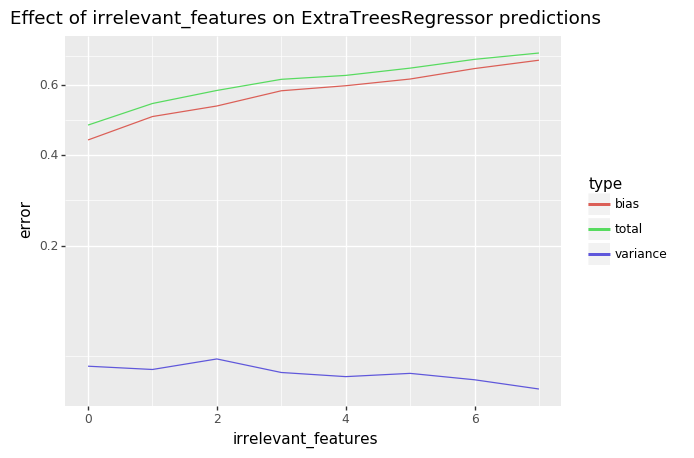

<ggplot: (305800737)>

In [14]:
plot_dataset_bias_variance(ExtraTreesRegressor(100, max_features=1), 'irrelevant_features', range(8))

... decreases "effective dataset size" only when decisions are made based on that feature. Consequently it only increases bias for regressors that look at features seperately. 